# Detection of Pnumonia
This project is  classification algorithm which classifies whether a patient has pneumonia in his/her lungs judging by that patient’s X-Ray image of the chest.

Dataset was taken from https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia
This will be a binary classification model.

The picture below is a chest X-Ray phtograph of normal person.

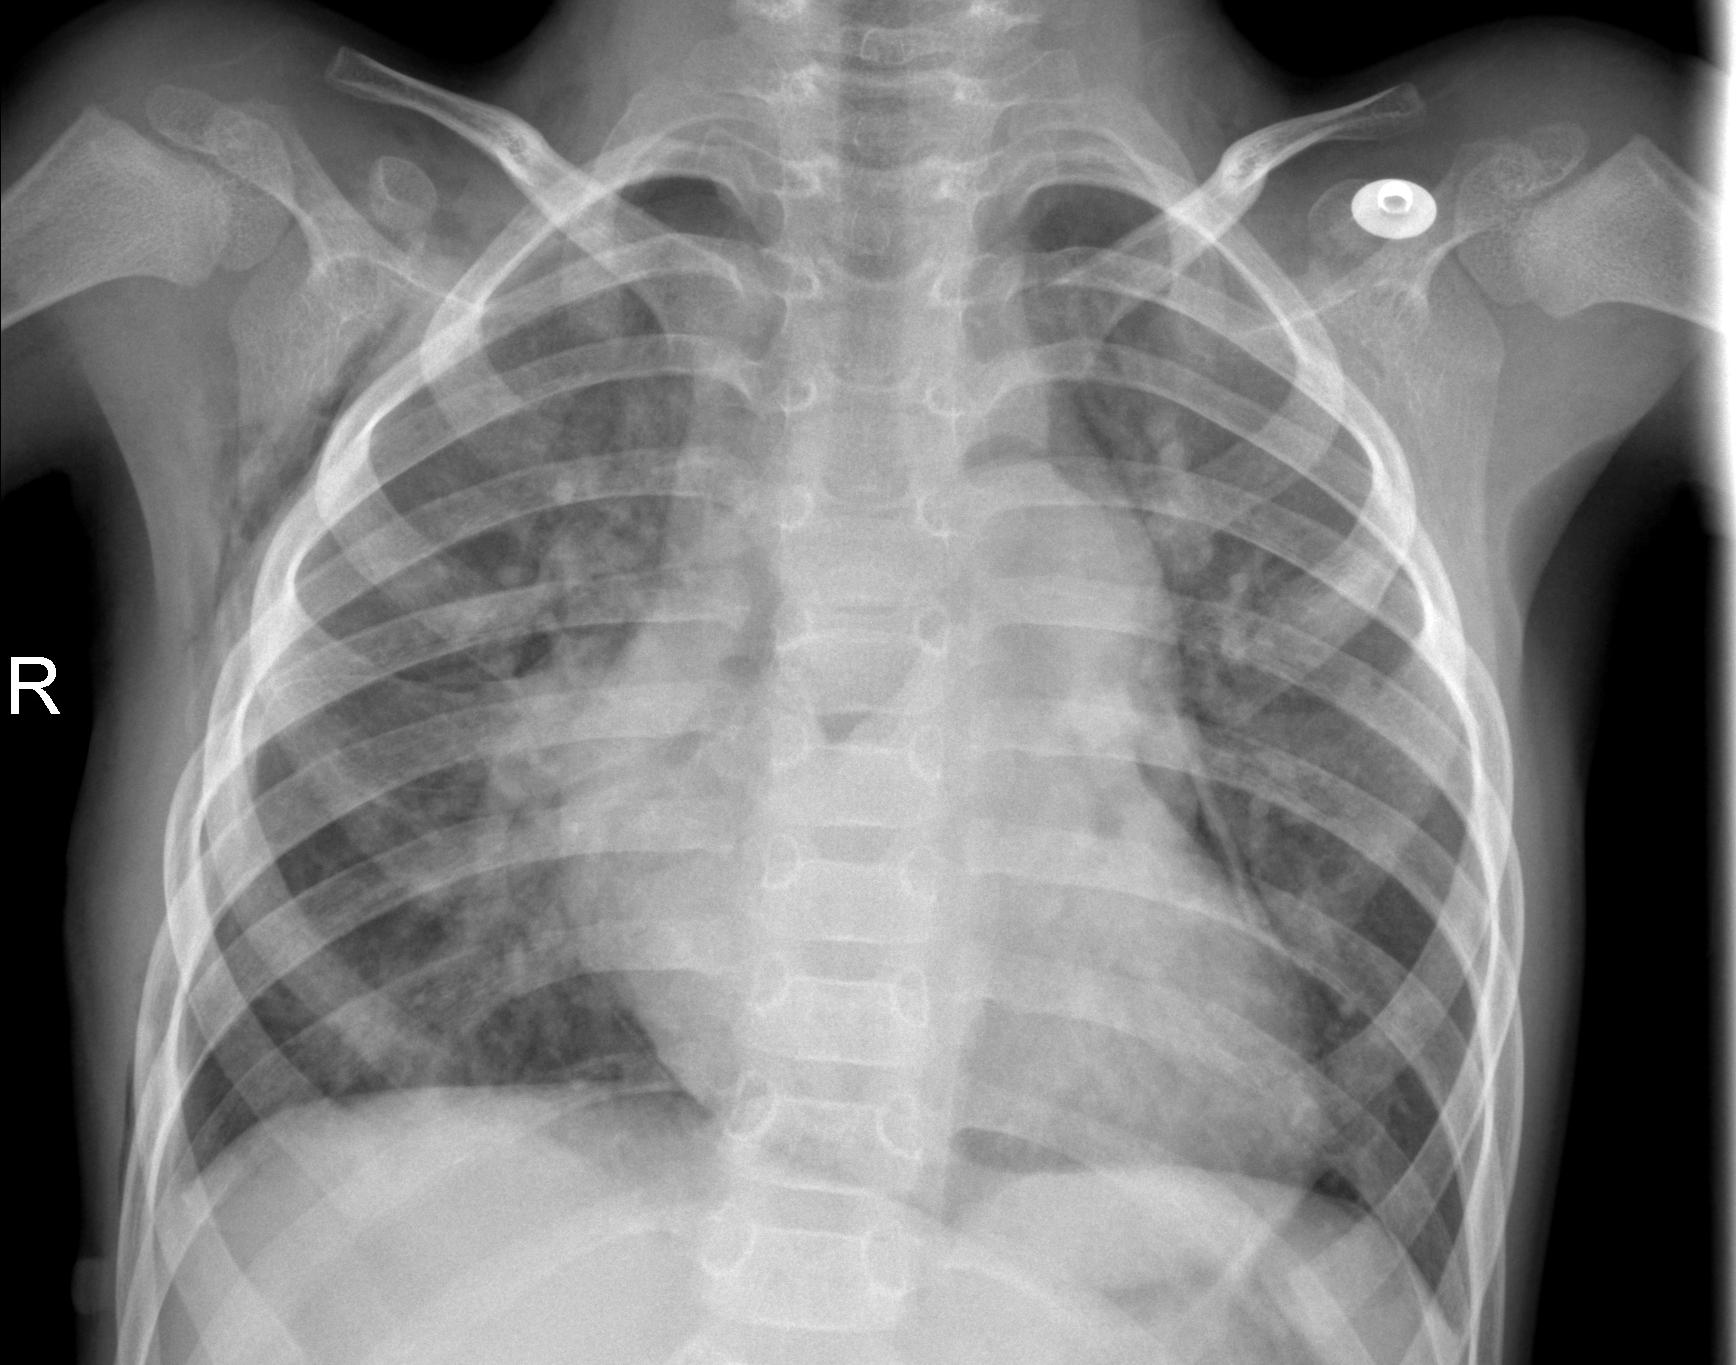

# Methods to solve a problem.

1. Transfer Learning + Logistic Regression
2. Transfer Learning + kNN
3. Transfer Learning + PCA + SVM

# Importing Libraries

I will use sklearn libarary for PCA, confusion matrix, and classification report. However methods are written from scratch

In [1]:
import numpy as np
from sklearn.decomposition import PCA
from timeit import default_timer as timer
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from random import randrange

# Importing features from Transfer Learning (VGG16)
The features are evaluated in extractor.ipynb 

In [2]:
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

# Logistic Regresssion Class
Learining rate and number of iterations are fixed if not given in constructor. The fit_intercept is answer for a model if it needs coloumn of 1 in the beginning of feature matrix. Threshold for classisfication is 0.5

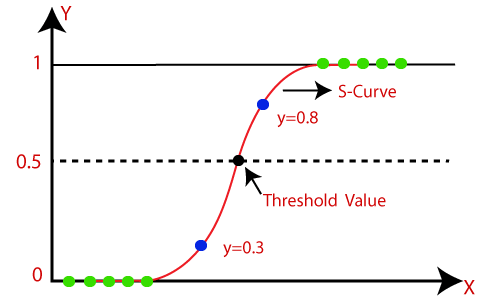

In [3]:
class LogisticRegression:
    def __init__(self, lr=0.01, num_iter=1000, fit_intercept=True):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    
    def return_loss(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        z = np.dot(X, self.theta)
        h = self.__sigmoid(z)
        result = self.__loss(h,y)
        return result  

        
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient
          
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X, threshold = 0.5):
        return self.predict_prob(X) >= threshold

# kNN class
It classifies a label to most frequent among k nearest neighbors. Neighborhood is determined by Euclidean distance.

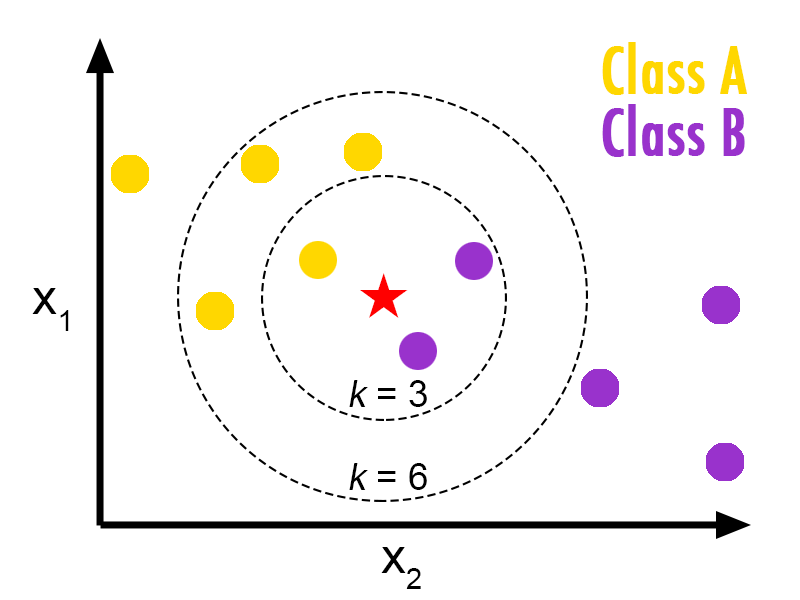

In [4]:
class simple_knn():
    "a simple kNN with L2 distance"

    def __init__(self):
        pass

    def train(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1):
        dists = self.compute_distances(X)
        # print("computed distances")

        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)

        for i in range(num_test):
            k_closest_y = []
            labels = self.y_train[np.argsort(dists[i,:])].flatten()
            # find k nearest lables
            k_closest_y = labels[:k]

           
            c = Counter(k_closest_y)
            y_pred[i] = c.most_common(1)[0][0]

        return(y_pred)

    def compute_distances(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]

        dot_pro = np.dot(X, self.X_train.T)
        sum_square_test = np.square(X).sum(axis = 1)
        sum_square_train = np.square(self.X_train).sum(axis = 1)
        dists = np.sqrt(-2 * dot_pro + sum_square_train + np.matrix(sum_square_test).T)

        return(dists)

# SVM class
Classification with binary linear kernel SVM. Loss function is Hinge loss with lasso regulirization.

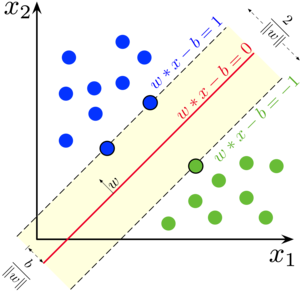

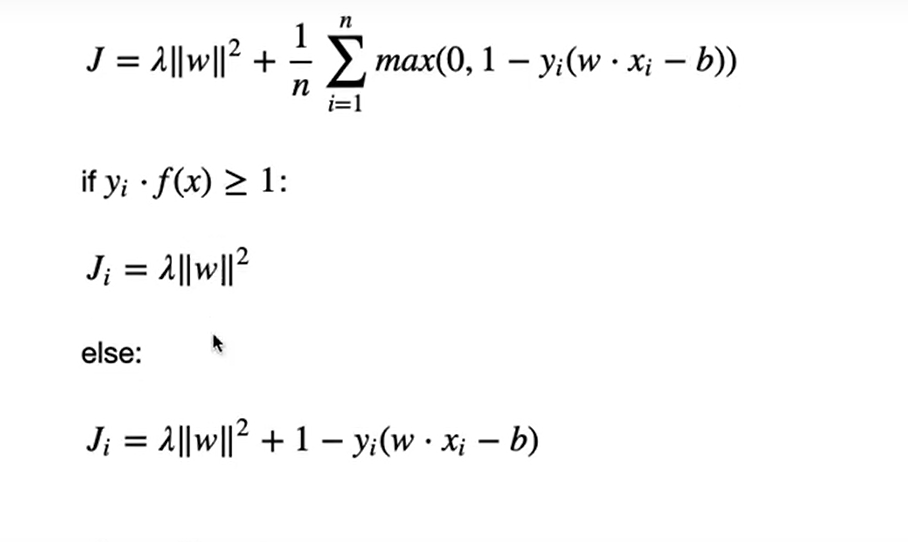

In [5]:
class SVM:

    def __init__(self, learning_rate=0.0001, lambda_param=0.0001, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None


    def return_loss(self,X,y):
        n_samples, n_features = X.shape
        
        y_ = np.where(y <= 0, -1, 1)
        loss = 0
        
        
        for idx, x_i in enumerate(X):
            condition = y_[idx] * (np.dot(x_i, self.w) - self.b) < 1
            if condition:
                loss += 1-y_[idx] * (np.dot(x_i, self.w) - self.b) 
        
        loss /= n_samples
        loss +=  0.0001*( np.square(self.w).sum() )
        return loss
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        y_ = np.where(y <= 0, -1, 1)
        
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]


    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

#  k-fold cross validation function

In [6]:
# Split a dataset into k folds
def cross_validation_split(dataset, folds=3):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / folds)
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return np.array(dataset_split)

# Creating 5 folds from training data

In [7]:
data = np.concatenate((X_train, np.expand_dims(y_train, axis=1)), axis=1)
print(data.shape)

folds = cross_validation_split(data, folds=5)
print(folds.shape)
print(folds[0][:,:-1].shape)

(5210, 4097)
(5, 1042, 4097)
(1042, 4096)


# Validation on logistic regression to find optimal number of iterations 

In [8]:
start = timer()
iterations = np.array([100,250,500,750,1000])
log_reg_train_loss = []
log_reg_val_loss = []
log_reg_train_accuracy = []
log_reg_val_accuracy = []

temp = 0


for i in range(5):
    val_set_logreg = np.array([])
    train_set_logreg = np.array([])
    for j in range(5):
        if j == i:
            val_set_logreg =folds[i]
        
        elif temp == 0:
            train_set_logreg =folds[i]
            temp =1
        else:
            train_set_logreg = np.concatenate( (train_set_logreg, folds[j]), axis = 0 )
    
    temp = 0
    
    val_label_logreg = val_set_logreg[:,-1]
    val_set_logreg = val_set_logreg[:,:-1]
    train_label_logreg = train_set_logreg[:,-1]
    train_set_logreg = train_set_logreg[:,:-1]
    model = LogisticRegression(lr=0.01, num_iter =iterations[i])
    %time model.fit(train_set_logreg, train_label_logreg)
    pred_train_logreg = model.predict(train_set_logreg)
    pred_val_logreg = model.predict(val_set_logreg)
    
    log_reg_train_accuracy.append(100*(pred_train_logreg == train_label_logreg).mean())
    log_reg_val_accuracy.append(100*(pred_val_logreg == val_label_logreg).mean())
    log_reg_train_loss.append( model.return_loss(train_set_logreg, train_label_logreg) )
    log_reg_val_loss.append( model.return_loss(val_set_logreg, val_label_logreg) )


print("Total time {p:.2f} seconds".format(p = timer()-start))

Wall time: 1.5 s
Wall time: 3.54 s
Wall time: 6.83 s
Wall time: 11.1 s
Wall time: 13.9 s
Total time 38.97 seconds


# Plotting results

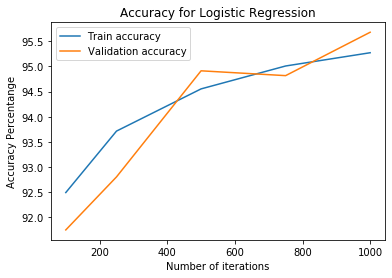

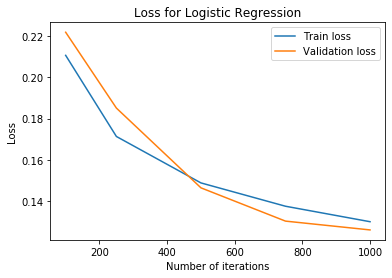

In [9]:
plt.plot(iterations,log_reg_train_accuracy, label = "Train accuracy" )
plt.plot(iterations,log_reg_val_accuracy, label = "Validation accuracy")
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy Percentange')
plt.title('Accuracy for Logistic Regression')
plt.legend()
plt.show()

plt.plot(iterations,log_reg_train_loss, label = "Train loss" )
plt.plot(iterations,log_reg_val_loss, label = "Validation loss")
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.title('Loss for Logistic Regression')
plt.legend()
plt.show()

# Optimal is 750

In [10]:
model = LogisticRegression(num_iter =750)
%time model.fit(X_train, y_train)
pred_log_reg = model.predict(X_test)
print("Accuracy {p:.2f} %".format(p = 100*(pred_log_reg == y_test).mean() ))

Wall time: 12.8 s
Accuracy 82.10 %


# Validation on kNN to find optimal value for k 

In [11]:
start = timer()
num_k = np.array([3,5,7,9,11])
accuracy_knn = []

for i in range(5):
    val_set_knn = np.array([])
    train_set_knn = np.array([])
    for j in range(5):
        if j == i:
            val_set_knn =folds[i]
        
        elif temp == 0:
            train_set_knn =folds[i]
            temp =1
        else:
            train_set_knn = np.concatenate( (train_set_knn, folds[j]), axis = 0 )
    
    temp = 0
    
    val_label_knn = val_set_knn[:,-1]
    val_set_knn = val_set_knn[:,:-1]
    train_label_knn = train_set_knn[:,-1]
    train_set_knn = train_set_knn[:,:-1]
    
    model_knn = simple_knn()
    model_knn.train(train_set_knn, train_label_knn)
    %time predictions_knn = model_knn.predict(val_set_knn, k =num_k[i])
    accuracy_knn.append(100*(predictions_knn == val_label_knn).mean())
print("Total time {p:.2f} seconds".format(p = timer()-start))

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sqrt


Wall time: 1.46 s
Wall time: 1.44 s
Wall time: 1.38 s
Wall time: 1.5 s
Wall time: 1.44 s
Total time 7.96 seconds


# Plotting results

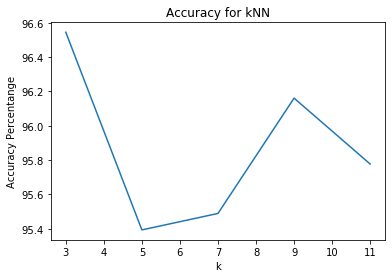

In [12]:
plt.plot(num_k,accuracy_knn)
plt.xlabel('k')
plt.ylabel('Accuracy Percentange')
plt.title('Accuracy for kNN')
plt.show()

# Optimal value for k is 7

In [13]:
model_knn = simple_knn()
model_knn.train(X_train, y_train)
%time prediction_knn = model_knn.predict(X_test, k =7)
print("Accuracy {p:.2f} %".format(p = 100*(prediction_knn == y_test).mean() ))

Wall time: 942 ms
Accuracy 82.10 %


# Dimensionality reduction is needed.
SVM is not good choice if number of features exceeds 100. Principle Component Analysis(PCA) is used to solve this problem. First 100 principle components are chosen.

In [14]:
pca = PCA(n_components=100)
pca.fit(X_train)
X_train_small = pca.transform(X_train)
X_test_small = pca.transform(X_test)

# Creating 5 folds for new features.
Since feature matrix is changed, new folds are needed.

In [15]:
data = np.concatenate((X_train_small, np.expand_dims(y_train, axis=1)), axis=1)
print(data.shape)

folds_small = cross_validation_split(data, folds=5)
print(folds.shape)

(5210, 101)
(5, 1042, 4097)


# Validation on SVM to find optimal value for number of iterations.

In [16]:
start = timer()
num_iter= [100, 250, 500, 750, 1000]

trin_accuracy_svm = []
val_accuracy_svm = []
train_loss_svm = []
val_loss_svm = []

for i in range(5):
    val_set_svm = np.array([])
    train_set_svm = np.array([])
    for j in range(5):
        if j == i:
            val_set_svm =folds_small[i]
        
        elif temp == 0:
            train_set_svm =folds_small[i]
            temp =1
        else:
            train_set_svm = np.concatenate( (train_set_svm, folds_small[j]), axis = 0 )
    
    temp = 0
    
    val_label_svm = val_set_svm[:,-1]
    val_set_svm = val_set_svm[:,:-1]
    train_label_svm = train_set_svm[:,-1]
    train_set_svm = train_set_svm[:,:-1]
    
    model_svm = SVM(n_iters = num_iter[i])
    model_svm.fit(train_set_svm, train_label_svm)
    
    val_ = np.where(val_label_svm <= 0, -1, 1)
    train_ = np.where(train_label_svm <= 0, -1, 1)
    
    predictions_train_svm = model_svm.predict(train_set_svm)
    predictions_val_svm = model_svm.predict(val_set_svm)
    
    trin_accuracy_svm.append(100*(predictions_train_svm == train_).mean())
    val_accuracy_svm.append(100*(predictions_val_svm == val_).mean())
    
    train_loss_svm.append(model_svm.return_loss(train_set_svm, train_) )
    val_loss_svm.append(model_svm.return_loss(val_set_svm, val_) )
    
print("Total time {p:.2f} seconds".format(p = timer()-start))

Total time 93.18 seconds


# Plotting the results

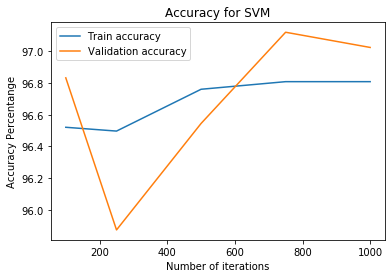

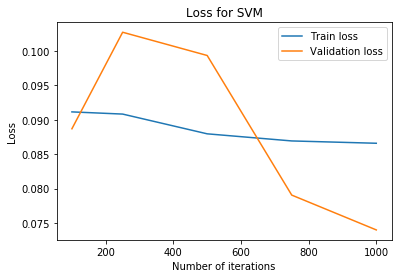

In [17]:
plt.plot(num_iter,trin_accuracy_svm, label = "Train accuracy" )
plt.plot(iterations,val_accuracy_svm, label = "Validation accuracy")
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy Percentange')
plt.title('Accuracy for SVM')
plt.legend()
plt.show()

plt.plot(iterations,train_loss_svm, label = "Train loss" )
plt.plot(iterations,val_loss_svm, label = "Validation loss")
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.title('Loss for SVM')
plt.legend()
plt.show()

# 750 is optimal

In [19]:
start = timer()
clf = SVM(n_iters = 750)
clf.fit(X_train_small, y_train)
prediction_svm = clf.predict(X_test_small)
y_ = np.where(y_test <= 0, -1, 1)
print("Accuracy {p:.2f} %".format(p = 100*(prediction_svm == y_).mean() ))
prediction_svm  =np.where(prediction_svm < 0, 0, 1)
print("Total time {p:.2f} seconds".format(p = timer()-start))

Accuracy 83.71 %
Total time 31.80 seconds


# Creating confusion matrix and classification report to campare all methods

In [21]:
print('Confusion Matrix for Logistic regression')
print(confusion_matrix(y_test, pred_log_reg))
print('\n\nClassification Report for Logistic regression')
target_names = ['Normal', 'Pneumonia']
print(classification_report(y_test, pred_log_reg, target_names=target_names))


print('\n\nConfusion Matrix for kNN')
print(confusion_matrix(y_test, prediction_knn))
print('\n\nClassification Report for kNN')
print(classification_report(y_test, prediction_knn, target_names=target_names))


print('\n\nConfusion Matrix for SVM')
print(confusion_matrix(y_test, prediction_svm))
print('\n\nClassification Report for SVM')
print(classification_report(y_test, prediction_svm, target_names=target_names))

Confusion Matrix for Logistic regression
[[127 103]
 [  8 382]]


Classification Report for Logistic regression
              precision    recall  f1-score   support

      Normal       0.94      0.55      0.70       230
   Pneumonia       0.79      0.98      0.87       390

    accuracy                           0.82       620
   macro avg       0.86      0.77      0.78       620
weighted avg       0.84      0.82      0.81       620



Confusion Matrix for kNN
[[130 100]
 [ 11 379]]


Classification Report for kNN
              precision    recall  f1-score   support

      Normal       0.92      0.57      0.70       230
   Pneumonia       0.79      0.97      0.87       390

    accuracy                           0.82       620
   macro avg       0.86      0.77      0.79       620
weighted avg       0.84      0.82      0.81       620



Confusion Matrix for SVM
[[132  98]
 [  3 387]]


Classification Report for SVM
              precision    recall  f1-score   support

      Normal   

# Ranking of methods are as follows:

# 1) SVM
Better than others in all aspects.


# 2) Logistic Regression
Since correct classification of Pneumonia is more important than normal class, it is slightly better than kNN 

# 3) kNN